# Glycolytic Oscillation in Yeast

Glycolysis is a process by which a glucose molecule is broken down into smaller molecules in both prokaryotes and eukaryotes. One of its primary roles is producing adenosine triphosphate (ATP) under conditions where respiration is absent. Glycolytic oscillations may appear in cell-free extracts or dense suspensions of non-growing cells of yeast *Saccharomyces cerevisiae* under starvation. The oscillations are primarily driven by the interaction of adenosine diphosphate (ADP) and ATP. This interaction serves as a basis for the popular Selkov model of glycolytic oscillations. The following form of the Selkov model has been used:

$$
\begin{align}
    \frac{dx}{dt} &= a +  x^2 y - x, \\
    \frac{dy}{dt} &= b - x^2 y.
\end{align}
$$

where $ x$ and $ y $ are dimensionless variables that may represent ADP and ATP concentration, respectively.

## Parameters
- $ a = 0.1 $
- $b = 0.2 $


In [1]:
import os, sys
print(sys.version)
print("_"* 60)
print(sys.executable)
print("_"* 60)

3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]
____________________________________________________________
/home/alka23224/miniconda3/envs/implicit_sindy/bin/python
____________________________________________________________


In [2]:
os.environ["PATH"] = ("/home/alka23224/miniconda3/envs/implicit_sindy/bin:" + os.environ["PATH"])

In [3]:
# -------------------------------
# Current working directory
# -------------------------------
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")


Current working directory: /home/alka23224/Chapter_5_SINDy


In [4]:
# -------------------------------
plot_dir = os.path.join(current_dir, "Plots")
os.makedirs(plot_dir, exist_ok=True) 

In [5]:
# -----------------------------
# Import Necessary Libraries
# -----------------------------
import numpy as np
import pandas as pd
import pysindy as ps
import sympy as sp
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import LogFormatter
import plotly.graph_objects as go
from sympy import symbols, Eq, solve, Matrix, N, simplify, nsimplify
from IPython.display import display
from IPython.display import Image
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from pysindy.differentiation import SmoothedFiniteDifference
from pysindy.feature_library import CustomLibrary
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.notebook import tqdm

In [6]:
import warnings
# Ignore all UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)

In [7]:
# Import helper
from plot_utils import set_plot_style, set_spines_black, set_spines_black_3d
from symbolic_parser import build_expr_map, build_symbolic_rhs
from network_utils import draw_network

In [8]:
# -------------------------------------------
# Define symbolic variable and parameters
# -------------------------------------------
x, y = sp.symbols('x y')
a, b = 0.1, 0.2
dx_dt = a + x**2*y - x
dy_dt = b - x**2*y 
# Display the ODE
print("The system of ODEs:")
print("dx_dt =", dx_dt)
print("dy_dt =", dy_dt)

The system of ODEs:
dx_dt = x**2*y - x + 0.1
dy_dt = -x**2*y + 0.2


In [9]:
# --------------------------------
# Define the Glycolytic Oscillation Model
def glycolytic_oscillations(t,state, a, b):
    x, y = state  
    dx_dt = a + x**2*y - x
    dy_dt = b - x**2*y 
    return [dx_dt, dy_dt]


## Training data 
# Parameters for ODE Integrator 
t0 = 0
tf_train= 100 # Maximum time for the simulation
dt = 0.001  # The time step
t_train= np.arange(t0,tf_train+dt,dt) # Time points for simulation
X0 = [0, 0]  # Initial state of the system

# Solve with solve_ivp
X = solve_ivp(
    glycolytic_oscillations,
    t_span=[t0, tf_train],
    y0=X0,
    args=(a, b),
    t_eval=t_train,  
    method='LSODA'    
)

x_train = X.y.T  
 

## Test Data
# Parameters for ODE Integrator 
tf_test = 50  # Maximum time for the simulation
dt = 0.001  # Time step
t_test = np.arange(0, tf_test, dt)  # Time points for simulation
X0_test = [0.4, 0.3]  # Initial state of the system
# Solve with solve_ivp
Xt = solve_ivp(
    glycolytic_oscillations,
    t_span=[t0, tf_test],
    y0=X0_test,
    args=(a, b),
    t_eval=t_test,  
    method='LSODA'    
)

x_test = Xt.y.T  


In [10]:
# Print sizes of t_train, x_train, x_test 
print("Size of t_train:", t_train.shape)
print("Size of x_train:", x_train.shape)
print("Size of x_test:", x_test.shape)

Size of t_train: (100001,)
Size of x_train: (100001, 2)
Size of x_test: (50000, 2)


In [11]:
# -----------------------------------
# To fit SINDy model using x_train
# -----------------------------------

In [12]:
model = ps.SINDy()
print(model)

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=PolynomialLibrary(), optimizer=STLSQ())


In [13]:
# 1) 
# -----------------------------------
#  Differentiation Method
# -----------------------------------
differentiation_method = SmoothedFiniteDifference()

In [14]:
# 2) Feature Library 
# -----------------------------------
#  Create library : Theta(x)
# -----------------------------------
# [Terms Present in the ODEs]
library = [
    lambda x, y: 1,
    lambda x, y: x,
    # lambda x, y: y,
    # lambda x, y: x**2,
    # lambda x, y: x * y,
    lambda x, y: x**2 * y,
]
library_names = [
    lambda x, y: "1",
    lambda x, y: "x",
    # lambda x, y: "y",
    # lambda x, y: "x²",
    # lambda x, y: "xy",
    lambda x, y: "x^2y"
]
custom_library = ps.CustomLibrary(
    library_functions=library,
    function_names=library_names).fit(x_train)

print(custom_library.get_feature_names())

['1', 'x', 'x^2y']


In [15]:
## Define the Optimizer
sindy_optimizer = ps.STLSQ( 
    max_iter=50000,
    normalize_columns=False
)
## Initialize the SINDy model
model = ps.SINDy(
    optimizer=sindy_optimizer,
    feature_library=custom_library,
    feature_names=["x", "y"]
)
## Fit the SINDy model
model.fit(x_train, t=dt)

# Print the Learned Equations
print("The equations learned using SINDy:")
model.print(lhs=["dx/dt", "dy/dt"])

The equations learned using SINDy:
dx/dt = 0.100 1 + -1.000 x + 1.000 x^2y
dy/dt = 0.200 1 + -1.000 x^2y


In [16]:
print('The total number of terms present in the model:', model.complexity)

The total number of terms present in the model: 5


In [17]:
library_name = model.get_feature_names()
sindy_coefficients = np.round(model.coefficients(),3)
sindy_result =pd.DataFrame(sindy_coefficients,
                                 index=["dx/dt", "dy/dt"],
                                 columns=library_name)
# Display the DataFrame
print("SINDy Result:")
print(sindy_result)

SINDy Result:
         1    x  x^2y
dx/dt  0.1 -1.0   1.0
dy/dt  0.2  0.0  -1.0


In [18]:
# Simulate using the learned model
x_train_simulated = model.simulate(x_train[0], t_train)

In [19]:
forward_time = np.arange(0, tf_train + 100, dt)
x_train_simulated_forward = model.simulate(x_train[0], forward_time)

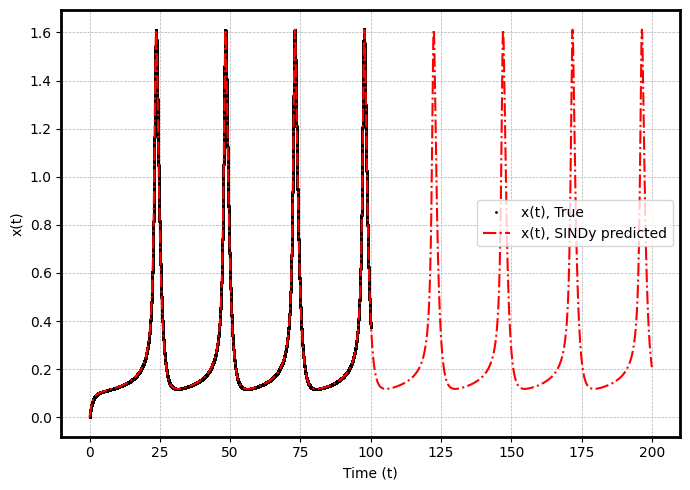

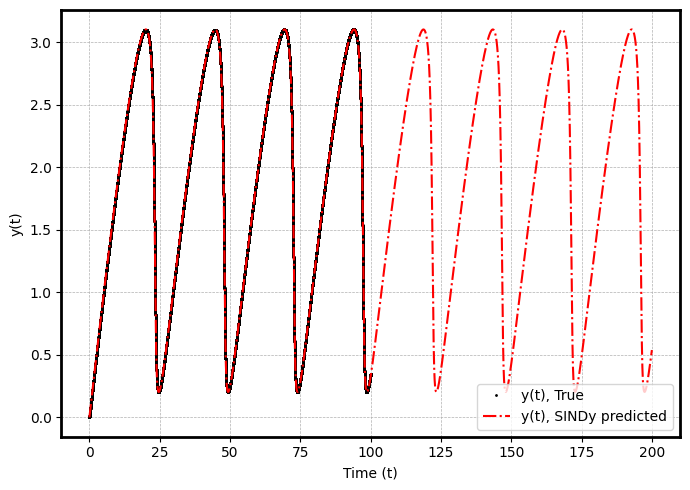

In [20]:
## Plot the results
# Plot x(t) 
fig1, ax1 = plt.subplots(figsize=(7, 5), dpi=100)
ax1.plot(t_train, x_train[:, 0], 'k.', label='x(t), True', markersize=2)
ax1.plot(forward_time, x_train_simulated_forward[:, 0], 'r-.',
         label='x(t), SINDy predicted', linewidth=1.5)
ax1.set(xlabel='Time (t)', ylabel='x(t)')
ax1.grid(True, which='both', ls='--', lw=0.5)
ax1.legend()
set_spines_black(ax1)
fig1.tight_layout()
plt.show()

# Plot y(t) 
fig2, ax2 = plt.subplots(figsize=(7, 5), dpi=100)
ax2.plot(t_train, x_train[:, 1], 'k.', label='y(t), True', markersize=2)
ax2.plot(forward_time, x_train_simulated_forward[:, 1], 'r-.',
         label='y(t), SINDy predicted', linewidth=1.5)
ax2.set(xlabel='Time (t)', ylabel='y(t)')
ax2.grid(True, which='both', ls='--', lw=0.5)
ax2.legend()
set_spines_black(ax2)
fig2.tight_layout()
plt.show()

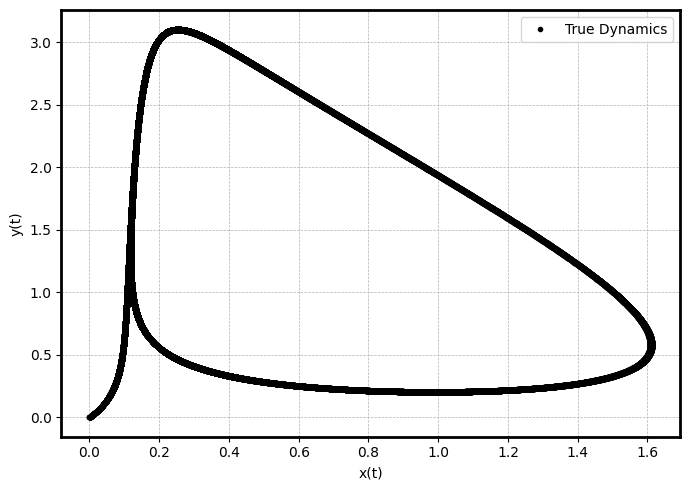

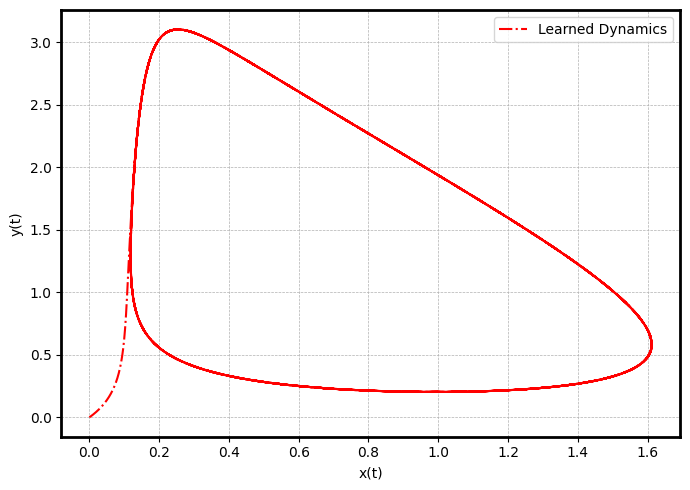

In [21]:
# Phase Digram
# True Dynamics 
fig1, ax1 = plt.subplots(figsize=(7, 5), dpi=100)
ax1.plot(x_train[:, 0], x_train[:, 1], 'k.', label='True Dynamics')
ax1.set(xlabel='x(t)', ylabel='y(t)')
ax1.grid(True, which='both', ls='--', lw=0.5)
ax1.legend(loc='best')
set_spines_black(ax1)     
fig1.tight_layout()
plt.show()


# Learned Dynamics
fig2, ax2 = plt.subplots(figsize=(7, 5), dpi=100)
ax2.plot(x_train_simulated_forward[:, 0],
         x_train_simulated_forward[:, 1],
         'r-.',label='Learned Dynamics')
ax2.set(xlabel='x(t)', ylabel='y(t)')
ax2.grid(True, which='both', ls='--', lw=0.5)
ax2.legend(loc='best')
set_spines_black(ax2)     
fig2.tight_layout()
plt.show()


# **Interaction Network using Jacobian**

In [22]:
feature_names = model.get_feature_names()
coeffs = model.coefficients()

# Create symbolic expressions
dx_dt = build_symbolic_rhs(coeffs[0], feature_names)
dy_dt = build_symbolic_rhs(coeffs[1], feature_names)


In [23]:
# Now, to find steady states
steady_states = solve((Eq(dx_dt, 0),
                       Eq(dy_dt, 0)),
                       (x, y)) # Set each derivative equal to 0.
# Print each steady state
print("Steady states for the given system, are:")
for i, (x_ss, y_ss) in enumerate(steady_states, start=1):
    x_val = N(x_ss, 3)
    y_val = N(y_ss, 3)
    print(f"  Steady state {i}: (x, y) = ({x_val}, {y_val})")

Steady states for the given system, are:
  Steady state 1: (x, y) = (0.300, 2.22)


In [24]:
# Define the Jacobian matrix
vars = sp.Matrix([x, y])
f = sp.Matrix([dx_dt, dy_dt])
J = f.jacobian(vars).applyfunc(lambda expr: expr.evalf(3))

print("\nJacobian matrix:")
display(J)


Jacobian matrix:


Matrix([
[2.0*x*y - 1.0,  1.0*x**2],
[     -2.0*x*y, -1.0*x**2]])

In [25]:
# Evaluate the Jacobian at steady state 1
J_evaluated = J.subs({x: steady_states[0][0], y: steady_states[0][1]}).evalf(3)
display(J_evaluated)

Matrix([
[0.333,  0.0899],
[-1.33, -0.0899]])

In [26]:
eigs = J_evaluated.eigenvals() 
print("Eigenvalues at steady state 1:")
for ev, mult in eigs.items():
    print(f"  {N(ev,3)}  (multiplicity {mult})")

Eigenvalues at steady state 1:
  0.121 - 0.274*I  (multiplicity 1)
  0.121 + 0.274*I  (multiplicity 1)



The Interaction Network corresponding to this Jacobian Matrix is:


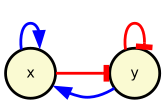

In [27]:
# Define the Jacobian matrix
nodes = ["x", "y"]
jacobian_matrix = np.array(J_evaluated.tolist(), dtype=float)
# Draw the network
graph = draw_network(jacobian_matrix,
                     nodes,
                     output_path='Glycolytic_SINDy',
                     label_fontsize=10,
                     graph_size='10,10',
                    dpi =100)
# Display the generated PNG
print(f"\nThe Interaction Network corresponding to this Jacobian Matrix is:")
Image(filename='Glycolytic_SINDy.png')

In [28]:
#------------------------------------------------------------------------------------------------------------------------------------------------#
#                                                                         END
#------------------------------------------------------------------------------------------------------------------------------------------------#